# Authentic vs Fake Banknote Classification

## Summary

The goal of this project is to determine whether a number of random banknotes can be accurately classified as authentic or fake. Through the use of a training set extracted from this dataset, we were able to create a KNN classification model and test our testing set to determine our accuracy. We then ran our unknown banknotes through our model and created visualizations to understand our banknotes better.

## Introduction

*Background information:*

Counterfeit currency is a global challenge that poses great threat to financial institutions, governments, and even individuals. To combat this, central banks and law enforcement agencies invest billions of dollars annually in anti-counterfeiting measures, such as watermarks, holograms, and security threads. However, while these methods help deter fraud, rapid advancements in printing technology and reproduction techniques have made counterfeiting even more complex and harder to detect. (National Research Council, 2006)

In Canada, for example, the Department of Justice reports that counterfeit money is one of the most common forms of financial fraud that is continuously adapting to improved security features and law enforcement tactics (Justice Canada, 2022). This ongoing challenge highlights the urgent need for more advanced detection methods that can quickly and accurately identify fraudulent banknotes. One of the most promising solutions is the use of automated detection systems powered by image processing and machine learning. By improving pattern recognition and statistical analysis, these models provide high precision, speed, and efficiency, making them a powerful tool in combating financial fraud (Bello, & Komolafe, 2024).

*Research Question:*

In this project we are trying to answer the question whether a machine learning model, specifically K-Nearest Neighbors (KNN), can effectively classify banknotes as genuine or counterfeit based on numerical image features. 

*The dataset:*

The dataset we used for this project is called "Banknote Authentication UCI data", and it was taken from the UCI Machine Learning Repository. This dataset is designed to distinguish between genuine and counterfeit banknotes using features extracted from their images. It comprises of 1372 individual data points that are characterized by four continuous features: variance, skewness, curtosis, entropy, and class. The target variable "class" is a binary value of 1 (counterfeit banknote) or 0 (genuine banknote). These features were extracted using wavelet transform tools applied to 400x400 pixel grayscale images captured by an industrial camera (Lohweg, 2012). 

## Methods & Results

### Import All Necessary Libraries

In [1]:
# Import all the libraries we need for the analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

### Loading Data From the Web

In [2]:
# Loading data from the web
# Data was downloaded from https://www.kaggle.com/datasets/ritesaluja/bank-note-authentication-uci-data/data



# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "BankNote_Authentication.csv"

# Load the latest version
bill_data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ritesaluja/bank-note-authentication-uci-data",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)
bill_data.to_csv("../data/original/BankNote_Authentication_saved.csv", index=False)
print("First 5 records:", bill_data.head())

C:\Users\Danny\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Danny\AppData\Local\Temp\ipykernel_944\1583559142.py:15: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  bill_data = kagglehub.load_dataset(


First 5 records:    variance  skewness  curtosis  entropy  class
0   3.62160    8.6661   -2.8073 -0.44699      0
1   4.54590    8.1674   -2.4586 -1.46210      0
2   3.86600   -2.6383    1.9242  0.10645      0
3   3.45660    9.5228   -4.0112 -3.59440      0
4   0.32924   -4.4552    4.5718 -0.98880      0


### Wrangle and Clean Data

In [3]:
# See if there are missing values
missing_values = bill_data.isna().sum().sum()
print(missing_values)

0


Since there are no missing values, we do not need to do any imputation relating to missing values.

### Summary of Dataset

In [4]:
# Create count table to see how many of each class there are
count_table = bill_data.groupby('class').size().reset_index(name='Count')
count_table['Percentage'] = 100 * count_table['Count'] / len(bill_data)

count_table

,class,Count,Percentage
0,0,762,55.539359
1,1,610,44.460641


#### Table 1. Authentic (0) to Fake (1) Proportion in Dataset

In [5]:
# Split data into training and testing sets
bill_train, bill_test = train_test_split(bill_data, test_size=0.25, stratify=bill_data['class'], random_state=1)
# Take a look at first 5 rows.
bill_train.head(5)

,variance,skewness,curtosis,entropy,class
892,0.21431,-0.69529,0.87711,0.29653,1
465,-2.69890,12.19840,0.67661,-8.54820,0
57,5.80700,5.00970,-2.23840,0.43878,0
1166,-2.19790,-2.12520,1.71510,0.45171,1
223,4.64640,10.53260,-4.58520,-4.20600,0


#### Table 2. Sample of Banknotes in Training Set

In [6]:
# Create class proportions table
class_proportions_table = bill_train.groupby('class').size().reset_index(name='Count')
class_proportions_table['Percentage'] = 100 * class_proportions_table['Count'] / len(bill_train)

class_proportions_table

# We notice that our "class" proportions were preserved when we split the data

,class,Count,Percentage
0,0,572,55.587949
1,1,457,44.412051


#### Table 3. Authentic (0) to Fake (1) Proportion in Training Dataset

In [7]:
# Compute mean for each factor
means_per_column = bill_train.iloc[:, :-1].mean().reset_index()
means_per_column.columns = ['Factor', 'Mean_Value']

means_per_column

,Factor,Mean_Value
0,variance,0.398695
1,skewness,1.837843
2,curtosis,1.462280
3,entropy,-1.192189


#### Table 4. Mean of Factors

In [8]:
# Compute max for each factor
max_per_column = bill_train.iloc[:, :-1].max().reset_index()
max_per_column.columns = ['Factor', 'Maximum_Value']

max_per_column

,Factor,Maximum_Value
0,variance,6.8248
1,skewness,12.6247
2,curtosis,17.6772
3,entropy,2.1625


#### Table 5. Maximium of Factors

In [9]:
# Compute min for each factor
min_per_column = bill_train.iloc[:, :-1].min().reset_index()
min_per_column.columns = ['Factor', 'Minimum_Value']

min_per_column

,Factor,Minimum_Value
0,variance,-7.0421
1,skewness,-13.6779
2,curtosis,-5.2861
3,entropy,-8.5482


#### Table 6. Minimum of Factors

## Visualizations of the Dataset

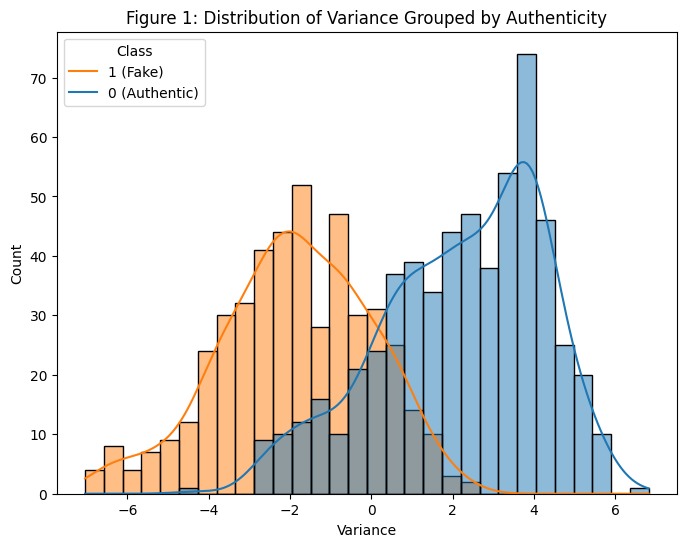

In [10]:
# Plot histogram of variance column distribution

plt.figure(figsize=(8, 6))
sns.histplot(data=bill_train, x='variance', hue='class', element='bars', bins=30, kde=True)
plt.xlabel("Variance")
plt.ylabel("Count")
plt.title("Figure 1: Distribution of Variance Grouped by Authenticity")
plt.legend(title="Class", labels=["1 (Fake)", "0 (Authentic)"])
plt.show()

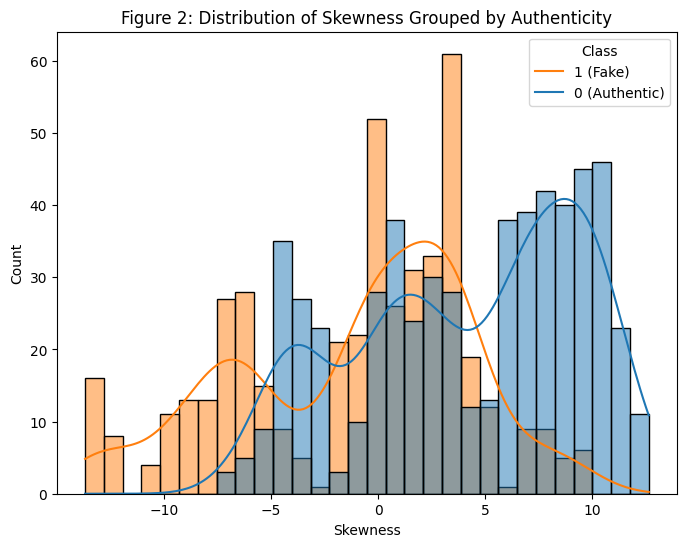

In [11]:
# Plot histogram of skewness column distribution

plt.figure(figsize=(8, 6))
sns.histplot(data=bill_train, x='skewness', hue='class', element='bars', bins=30, kde=True)
plt.xlabel("Skewness")
plt.ylabel("Count")
plt.title("Figure 2: Distribution of Skewness Grouped by Authenticity")
plt.legend(title="Class", labels=["1 (Fake)", "0 (Authentic)"])
plt.show()

### Figure 3. Distribution of Curtosis Grouped By Authentic or Fake

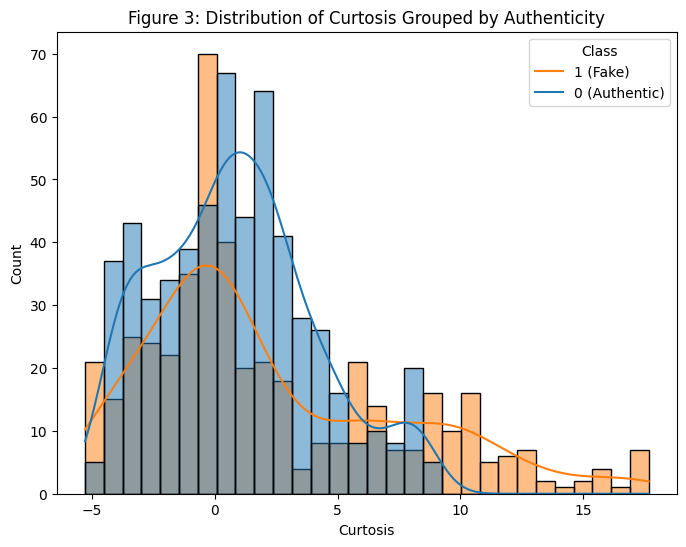

In [12]:
# Plot histogram of curtosis column distribution

plt.figure(figsize=(8, 6))
sns.histplot(data=bill_train, x='curtosis', hue='class', element='bars', bins=30, kde=True)
plt.xlabel("Curtosis")
plt.ylabel("Count")
plt.title("Figure 3: Distribution of Curtosis Grouped by Authenticity")
plt.legend(title="Class", labels=["1 (Fake)", "0 (Authentic)"])
plt.show()

### Figure 4. Distribution of Entropy Grouped By Authentic or Fake

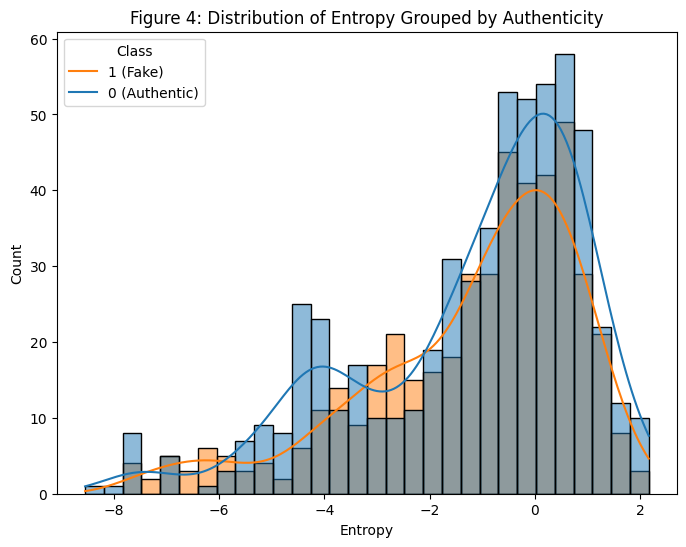

In [13]:
# Plot histogram of entropy column distribution

plt.figure(figsize=(8, 6))
sns.histplot(data=bill_train, x='entropy', hue='class', element='bars', bins=30, kde=True)
plt.xlabel("Entropy")
plt.ylabel("Count")
plt.title("Figure 4: Distribution of Entropy Grouped by Authenticity")
plt.legend(title="Class", labels=["1 (Fake)", "0 (Authentic)"])
plt.show()

#### Summary of Visualizations

The entropy histograms (Figure 4) have very similar distributions for authentic and fake bills as they both have their modes around 0. Since the distributions are very similar, it is very unlikely that entropy is a driving factor in determining authentic or fake bills. The same can be said for the curtosis histogram (Figure 3) as authentic and fake bills have similar distributions with their modes around 0 as well. Curtosis is also unlikely to be a driving force. The variance distributions (Figure 1) are very different. Both authentic and fake bills have a bell curve distribution with the fake bills having a mode around -2.5 and the authentic bills having a mode around 4. This suggests that variance is a very strong driving force in determining whether a bill is authentic or fake. The skewness histograms (Figure 2) have somewhat different distributions. The fake bills have their mode at around 2.5 while the authentic bills have their mode at around 8. The distributions overlap quite a bit suggesting that skewness is not as big of a driving factor as variance. These histograms will allow us to understand what we should expect with our unknown bill once the bill is identified. We can use these histograms to see if our expectations line up with the unknown bill.

## Data Analysis

### Cross validation

We tried standard scaler but got better results without it.

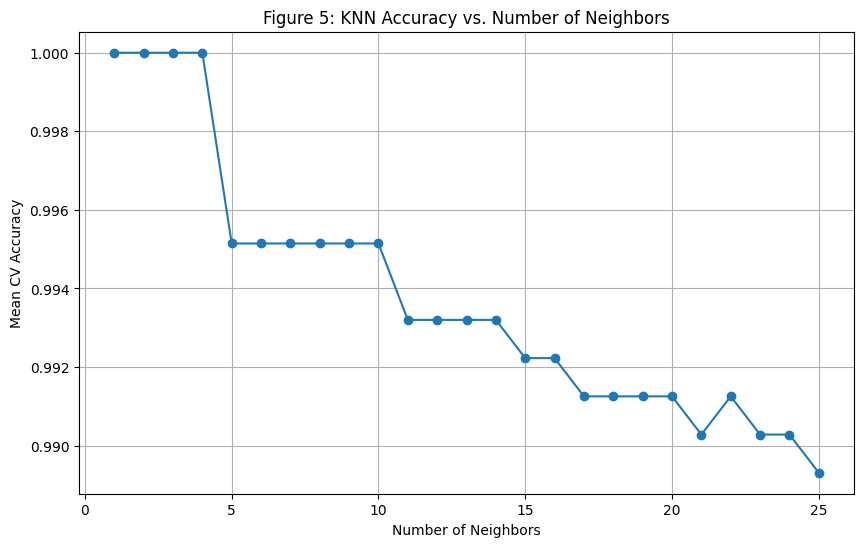

In [14]:
X_train = bill_train.drop('class', axis=1)  # features
y_train = bill_train['class']              # target

neighbors = range(1, 26)  # testing 1 to 25 neighbors
cv_scores = []

for k in neighbors:
    # Update the pipeline parameter for number of neighbors
    
    KNN = KNeighborsClassifier(n_neighbors= k)
    
    # Perform 5-fold cross-validation and record the mean accuracy
    scores = cross_val_score(KNN, X_train, y_train, cv=2)
    cv_scores.append(scores.mean())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(neighbors, cv_scores, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean CV Accuracy')
plt.title('Figure 5: KNN Accuracy vs. Number of Neighbors')
plt.grid(True)
plt.show()

### Parameter optimization

Seems like even with only one neighbour we are getting the best result, so let's go ahead and use only one neighbour in our pipeline and try it on the test set.

### Applying our findings on test data

In [15]:
X_test = bill_test.drop('class', axis=1)  # features
y_test = bill_test['class']              # target

FinalKNN = KNeighborsClassifier(n_neighbors= 1)

FinalKNN.fit(X_train,y_train)

FinalKNN.score(X_test,y_test)

1.0

### Predict Test Data Results
As we can see, we achieved a score of 1. Which means with no error we are predicting everything right. Lets explore that a bit more in terms of numbers of correct predictions. 

### Confusion Matrix

In [16]:
# Make predictions on the test set
y_pred = FinalKNN.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Figure 6: Confusion Matrix:")
print(cm)

# Optionally, print a classification report for additional metrics
print("\nFigure 7: Classification Report:")
print(classification_report(y_test, y_pred))

Figure 6: Confusion Matrix:
[[190   0]
 [  0 153]]

Figure 7: Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       190
           1       1.00      1.00      1.00       153

    accuracy                           1.00       343
   macro avg       1.00      1.00      1.00       343
weighted avg       1.00      1.00      1.00       343



### Interpretation:*  
Every test sample was classified correctly. There are no misclassifications, which implies that the model perfectly distinguishes between the two classes. 
### Key Metrics

- **Precision:**  
  - Class 0: 1.00  
  - Class 1: 1.00  
  Indicates that every instance predicted as a specific class was correct.

- **Recall:**  
  - Class 0: 1.00  
  - Class 1: 1.00  
  Indicates that the model successfully identified all instances for each class.

- **F1-Score:**  
  - Class 0: 1.00  
  - Class 1: 1.00  
  The harmonic mean of precision and recall, confirming overall perfect performance.

- **Support:**  
  - Class 0: 190 instances  
  - Class 1: 153 instances  
  The number of actual instances in each class within the test set.

- **Accuracy:**  
  - Overall: 1.00 (100%)  
  All 343 test samples were classified correctly.

The classifier achieved **100% accuracy** on the test set, with perfect precision, recall, and F1-scores for both classes. 


## Discussion

The classifier perfectly predicted all 190 real banknotes and 153 fake banknotes in the test set. This is not what we expected to find. While we did expect our model to do well since our 4 input variables likely play a major role in detecting forged banknotes, we did not expect it to perfectly predict every banknote in the test set.

However, upon further research, this model is fairly consistent with other models. A Gaussian process classifier was able to get 100% accuracy on both the training and test set with only 500 training samples (Grosse et al, 2018). A different model using convex optimzation on graphs also managed to achieve an average testing accuracy of 99.03% over 100 randomly generated training sets (Merkurjev et al, 2015). 

This result suggests that our current model is identifying all the patterns in the dataset and is able to predict whether or not a banknote is forged or not with 100% accuracy. However, this model still needs more testing. We could be overfitting on our available data. Our test set may also not capture all the patterns of a banknote the model might encounter, as it only has 343 samples. This test could have failed to include some rare or outlier patterns the model may encounter if it were tested on a different dataset. It may even be the case that our entire dataset may not be representative of the real world and this could potentially cause our model to perform poorly on unseen data. 

This analysis raises several potential future questions that could evaluate how this model would fare in real world scenarios:
- Would our model still be generalizable for larger or more complex datasets or would it lead to lower accuracy?
- Which of the 4 features between variance, skewness, kurtosis, and entropy are the most important for authenticating banknotes and by how much?
- Is there covariance between the 4 features? Does this covariance make it easier to detect fake banknotes?
- What are the patterns that make a counterfeit banknote stand out from a genuine banknote? Could a forged banknote be designed to avoid these patterns and not be detected by the classification model?

### References

- Bello, Oluwabusayo Adijat and Komolafe Olufemi. "Artificial intelligence in fraud prevention: Exploring techniques and applications challenges and opportunities." Computer Science & IT Research Journal (2024): n. pag. https://api.semanticscholar.org/CorpusID:270808704
- Grosse, Kathrin et al. "Killing Four Birds with one Gaussian Process: Analyzing Test-Time Attack Vectors on Classification." arXiv: Cryptography and Security, (2018): n. pag. https://api.semanticscholar.org/CorpusID:67856763
- Justice Canada. "The Links Between Substance Abuse and Crime in Canada." Government of Canada, (2022): https://www.justice.gc.ca/eng/rp-pr/csj-sjc/crime/rr02_3/p33.html.
- Lohweg, Volker. "Banknote Authentication." UCI Machine Learning Repository, (2012), https://doi.org/10.24432/C55P57.
- Merkurjev, Ekaterina et al. "Global Binary Optimization on Graphs for Classification of High-Dimensional Data." Journal of Mathematical Imaging and Vision 52, (2015): 414 - 435. https://api.semanticscholar.org/CorpusID:7832907
- National Research Council. "Is That Real? Identification and Assessment of the Counterfeiting Threat for U.S. Banknotes." The National Academies Press, (2006): https://nap.nationalacademies.org/catalog/11638/is-that-real-identification-and-assessment-of-the-counterfeiting-threat